## Code to extract features from PCAPS

In [12]:
import os
import time
import pandas as pd
from datetime import datetime, timedelta

from netunicorn.client.remote import RemoteClient, RemoteClientException
from netunicorn.base import Experiment, ExperimentStatus, Pipeline
from netunicorn.library.tasks.capture.tcpdump import StartCapture, StopNamedCapture
from netunicorn.library.tasks.upload.fileio import UploadToFileIO
from netunicorn.library.tasks.upload.webdav import UploadToWebDav
from netunicorn.library.tasks.basic import SleepTask
from netunicorn.library.tasks.measurements.ookla_speedtest import SpeedTest
#from netunicorn.library.tasks.video_watchers.youtube_watcher import WatchYouTubeVideo
#from netunicorn.library.tasks.video_watchers.vimeo_watcher import WatchVimeoVideo
#from netunicorn.library.tasks.video_watchers.twitch_watcher import WatchTwitchStream

import subprocess
from typing import Optional

from trustee import ClassificationTrustee
import matplotlib.pyplot as plt
from scapy.all import *
import pandas as pd
import numpy as np
import binascii
import ipaddress
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import plot_tree

In [13]:
crunchyroll_files = ["crunchyroll_120s_capture1.pcap_Flow.csv",
                      "crunchyroll_120s_capture2.pcap_Flow.csv",
                      "crunchyroll_120s_capture3.pcap_Flow.csv",
                      "crunchyroll_120s_capture4.pcap_Flow.csv",
                      "crunchyroll_120s_capture5.pcap_Flow.csv",
                      "crunchyroll_120s_capture6.pcap_Flow.csv",
                      "crunchyroll_120s_capture7.pcap_Flow.csv",
                      "crunchyroll_120s_retry_1.pcap_Flow.csv",
                      "crunchyroll_120s_retry_2.pcap_Flow.csv",
                      "crunchyroll_120s_retry_3.pcap_Flow.csv",
                      "crunchyroll_120s_retry_4.pcap_Flow.csv",
                      "crunchyroll_120s_retry_5.pcap_Flow.csv",
                      "crunchyroll_120s_retry_6.pcap_Flow.csv",
                      "crunchyroll_120s_retry_7.pcap_Flow.csv",
                      "crunchyroll_120s_retry_8.pcap_Flow.csv",
                      "crunchyroll_120s_retry_9.pcap_Flow.csv"]

df_crunchyroll = pd.DataFrame()

for file in crunchyroll_files:
    file_path = "/mnt/md0/cs190n/team_jv/" + file
    df_temp = pd.read_csv(file_path)
    
    df_temp['timestamp_column'] = pd.to_datetime(df_temp['Timestamp'])
    df_temp = df_temp.sort_values(by='timestamp_column')
    
    no_ad_time = df_temp['timestamp_column'][0] + timedelta(seconds=15)
    
    df_no_ads = df_temp[df_temp['timestamp_column'] >= no_ad_time]
    #print(df_no_ads)

    df_crunchyroll = pd.concat([df_crunchyroll, df_no_ads], ignore_index=True)
    
df_crunchyroll

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,timestamp_column
0,172.17.0.2-128.111.1.1-41946-53-17,172.17.0.2,41946,128.111.1.1,53,17,11/12/2023 02:11:01 AM,4176,1,1,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,NeedManualLabel,2023-11-12 02:11:01
1,172.17.0.2-142.250.72.170-55840-443-6,172.17.0.2,55840,142.250.72.170,443,6,11/12/2023 02:11:01 AM,51789403,17,17,...,52355.0,67383.033606,100002.0,4708.0,25840134.0,2.787343e+07,45549622.0,6130646.0,NeedManualLabel,2023-11-12 02:11:01
2,172.17.0.2-128.111.1.1-36133-53-17,172.17.0.2,36133,128.111.1.1,53,17,11/12/2023 02:11:01 AM,3220,1,1,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,NeedManualLabel,2023-11-12 02:11:01
3,172.17.0.2-128.111.1.1-48191-53-17,172.17.0.2,48191,128.111.1.1,53,17,11/12/2023 02:11:06 AM,3853,1,1,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,NeedManualLabel,2023-11-12 02:11:06
4,172.17.0.2-128.111.5.227-43556-443-6,172.17.0.2,43556,128.111.5.227,443,6,11/12/2023 02:11:06 AM,69135,10,11,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,NeedManualLabel,2023-11-12 02:11:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,172.17.0.2-128.111.5.227-44986-443-6,172.17.0.2,44986,128.111.5.227,443,6,14/12/2023 03:20:37 AM,44676,9,10,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,NeedManualLabel,2023-12-14 03:20:37
411,172.17.0.2-128.111.5.227-42476-443-6,172.17.0.2,42476,128.111.5.227,443,6,14/12/2023 03:21:07 AM,45582,9,10,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,NeedManualLabel,2023-12-14 03:21:07
412,172.17.0.2-128.111.1.1-49272-53-17,172.17.0.2,49272,128.111.1.1,53,17,14/12/2023 03:21:07 AM,1606,1,1,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,NeedManualLabel,2023-12-14 03:21:07
413,172.17.0.2-239.255.255.250-33097-1900-17,172.17.0.2,33097,239.255.255.250,1900,17,14/12/2023 03:21:13 AM,3013991,4,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,NeedManualLabel,2023-12-14 03:21:13


In [14]:
animepahe_files = ["animepahe_120s_capture1.pcap_Flow.csv",
                        "animepahe_120s_capture2.pcap_Flow.csv",
                        "animepahe_120s_capture3.pcap_Flow.csv",
                        "animepahe_120s_capture4.pcap_Flow.csv",
                        "animepahe_120s_capture5.pcap_Flow.csv",
                        "animepahe_120s_capture6.pcap_Flow.csv",
                        "animepahe_120s_capture7.pcap_Flow.csv",
                        "animepahe_120s_capture8.pcap_Flow.csv",
                        "animepahe_120s_retry_1.pcap_Flow.csv",
                        "animepahe_120s_retry_2.pcap_Flow.csv",
                        "animepahe_120s_retry_3.pcap_Flow.csv",
                        "animepahe_120s_retry_4.pcap_Flow.csv",
                        "animepahe_120s_retry_5.pcap_Flow.csv",
                        "animepahe_120s_retry_6.pcap_Flow.csv",
                        "animepahe_120s_retry_7.pcap_Flow.csv",
                        "animepahe_120s_retry_8.pcap_Flow.csv",
                        "animepahe_120s_retry_9.pcap_Flow.csv"]


df_animepahe = pd.DataFrame()

for file in animepahe_files:
    file_path = "/mnt/md0/cs190n/team_jv/" + file
    df_temp = pd.read_csv(file_path)
    
    df_temp['timestamp_column'] = pd.to_datetime(df_temp['Timestamp'])
    df_temp = df_temp.sort_values(by='timestamp_column')
    
    no_ad_time = df_temp['timestamp_column'][0] + timedelta(seconds=15)
    
    df_no_ads = df_temp[df_temp['timestamp_column'] >= no_ad_time]
    #print(df_no_ads)
    
    df_animepahe = pd.concat([df_animepahe, df_no_ads], ignore_index=True)
    
#df_animepahe

In [15]:
features = [
    "Label",
    'Src IP', 
    'Src Port',
    'Dst IP', 
    'Dst Port',
    "Protocol",
    'Total Fwd Packet', 
    'Total Bwd packets',
    "Flow Duration",
    "Flow Bytes/s",
    "Flow Packets/s",
    "Flow IAT Mean",
    "Bwd IAT Mean",
    "Down/Up Ratio",
    "Active Mean",
    "Idle Mean",
    "FWD Init Win Bytes",
    'Bwd Init Win Bytes',
    'FIN Flag Count', 
    'SYN Flag Count', 
    'RST Flag Count',
    'Packet Length Mean',
    'Timestamp'
    #'Packet Length Variance
]

In [16]:
# label sites from crunchy roll with total packets over 30
df_crunchyroll['Label'] = 'other'
df_crunchyroll.loc[(df_crunchyroll['Total Fwd Packet'] > 30) | (df_crunchyroll['Total Bwd packets'] > 30), 'Label'] = 'crunchyroll'  
df_crunchyroll = df_crunchyroll.drop(df_crunchyroll[(df_crunchyroll['Protocol'] == 17) & (df_crunchyroll['Label'] != 'crunchyroll')].index)

In [17]:
#df_crunchyroll

In [18]:
# label sites from animepahe with total packets over 30
df_animepahe['Label'] = 'other'
df_animepahe.loc[(df_animepahe['Total Fwd Packet'] > 30) | (df_animepahe['Total Bwd packets'] > 30), 'Label'] = 'animepahe'
df_animepahe = df_animepahe.drop(df_animepahe[(df_animepahe['Protocol'] == 17) & (df_animepahe['Label'] != 'animepahe')].index)

In [19]:
#df_animepahe

In [20]:
df = pd.concat([df_crunchyroll, df_animepahe], ignore_index=True)
df = df[features]
df = df.dropna()  # remove rows with Nones

df_labeled = df[df['Label'].isin(['crunchyroll', 'animepahe'])]

In [21]:
df_features = df_labeled.drop(['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp'], axis=1)
df_features

,Label,Total Fwd Packet,Total Bwd packets,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Bwd IAT Mean,Down/Up Ratio,Active Mean,Idle Mean,FWD Init Win Bytes,Bwd Init Win Bytes,FIN Flag Count,SYN Flag Count,RST Flag Count,Packet Length Mean
4,crunchyroll,891,4024,10822497,5.084002e+05,454.146580,2202.380342,2689.033060,4.0,0.0,0.0,64240,282,2,2,0,1119.235151
5,crunchyroll,29,36,9303794,2.228983e+03,6.986397,145371.781250,265621.400000,1.0,0.0,0.0,0,0,0,0,0,333.151515
8,crunchyroll,32,35,9797368,1.969713e+03,6.838571,148444.969697,287783.147059,1.0,0.0,0.0,0,0,0,0,0,302.176471
9,crunchyroll,372,1026,12856628,1.082648e+05,108.737688,9203.026485,12538.097561,2.0,0.0,0.0,64240,282,2,2,0,994.939242
11,crunchyroll,31,33,40598632,4.163194e+02,1.576408,644422.730159,547367.875000,1.0,17531317.0,23067315.0,0,0,0,0,0,279.261538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,animepahe,31,35,8860848,1.948346e+03,7.448497,136320.738462,260185.117647,1.0,0.0,0.0,0,0,0,0,0,276.328358
382,animepahe,172,581,1702239,2.074127e+06,442.358564,2263.615691,2929.631034,3.0,0.0,0.0,64240,277,2,2,0,4682.572944
383,animepahe,29,33,1659277,9.860921e+03,37.365672,27201.262295,51480.625000,1.0,0.0,0.0,0,0,0,0,0,279.555556
385,animepahe,418,824,58452727,8.607911e+04,21.247939,47101.311039,71020.008505,1.0,3027796.5,26196929.0,64240,282,2,2,0,4047.915527


## Model training using Random Forest Classifier

In [22]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [23]:
# imports
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import plot_tree

In [24]:
# separate the data frame to features and answers
target_variable = 'Label'
train_features = list(set(df_features.columns) - {target_variable})
x_train = df_features[train_features]
y_train = df_features[target_variable]

In [25]:
# initialize random forest classifier and input features with label
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

RandomForestClassifier()

In [26]:
# print out the predictions
y_pred = clf.predict(x_train.values)
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

   animepahe       1.00      1.00      1.00        77
 crunchyroll       1.00      1.00      1.00        72

    accuracy                           1.00       149
   macro avg       1.00      1.00      1.00       149
weighted avg       1.00      1.00      1.00       149



/home/vinsonlin/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Use Trustee to evaluate model

In [27]:
!pip install trustee

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


Training score of pruned DT: 1.0
Model explanation global fidelity report:
              precision    recall  f1-score   support

   animepahe       0.74      0.83      0.78        77
 crunchyroll       0.79      0.68      0.73        72

    accuracy                           0.76       149
   macro avg       0.76      0.76      0.76       149
weighted avg       0.76      0.76      0.76       149

Model explanation score report:
              precision    recall  f1-score   support

   animepahe       0.74      0.83      0.78        77
 crunchyroll       0.79      0.68      0.73        72

    accuracy                           0.76       149
   macro avg       0.76      0.76      0.76       149
weighted avg       0.76      0.76      0.76       149



/home/vinsonlin/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


[Text(0.5555555555555556, 0.9444444444444444, 'Packet Length Mean <= 1093.709\ngini = 0.5\nsamples = 73\nvalue = [37, 36]\nclass = animepahe'),
 Text(0.3333333333333333, 0.8333333333333334, 'Packet Length Mean <= 1067.874\ngini = 0.476\nsamples = 59\nvalue = [36, 23]\nclass = animepahe'),
 Text(0.2222222222222222, 0.7222222222222222, 'Total Bwd packets <= 34.5\ngini = 0.491\nsamples = 53\nvalue = [30, 23]\nclass = animepahe'),
 Text(0.1111111111111111, 0.6111111111111112, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]\nclass = animepahe'),
 Text(0.3333333333333333, 0.6111111111111112, 'Flow Bytes/s <= 1423.609\ngini = 0.499\nsamples = 48\nvalue = [25, 23]\nclass = animepahe'),
 Text(0.2222222222222222, 0.5, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = animepahe'),
 Text(0.4444444444444444, 0.5, 'Flow Bytes/s <= 2601.683\ngini = 0.499\nsamples = 44\nvalue = [21, 23]\nclass = crunchyroll'),
 Text(0.2222222222222222, 0.3888888888888889, 'Flow Duration <= 9736876.5\ngini = 0.26\nsamples = 1

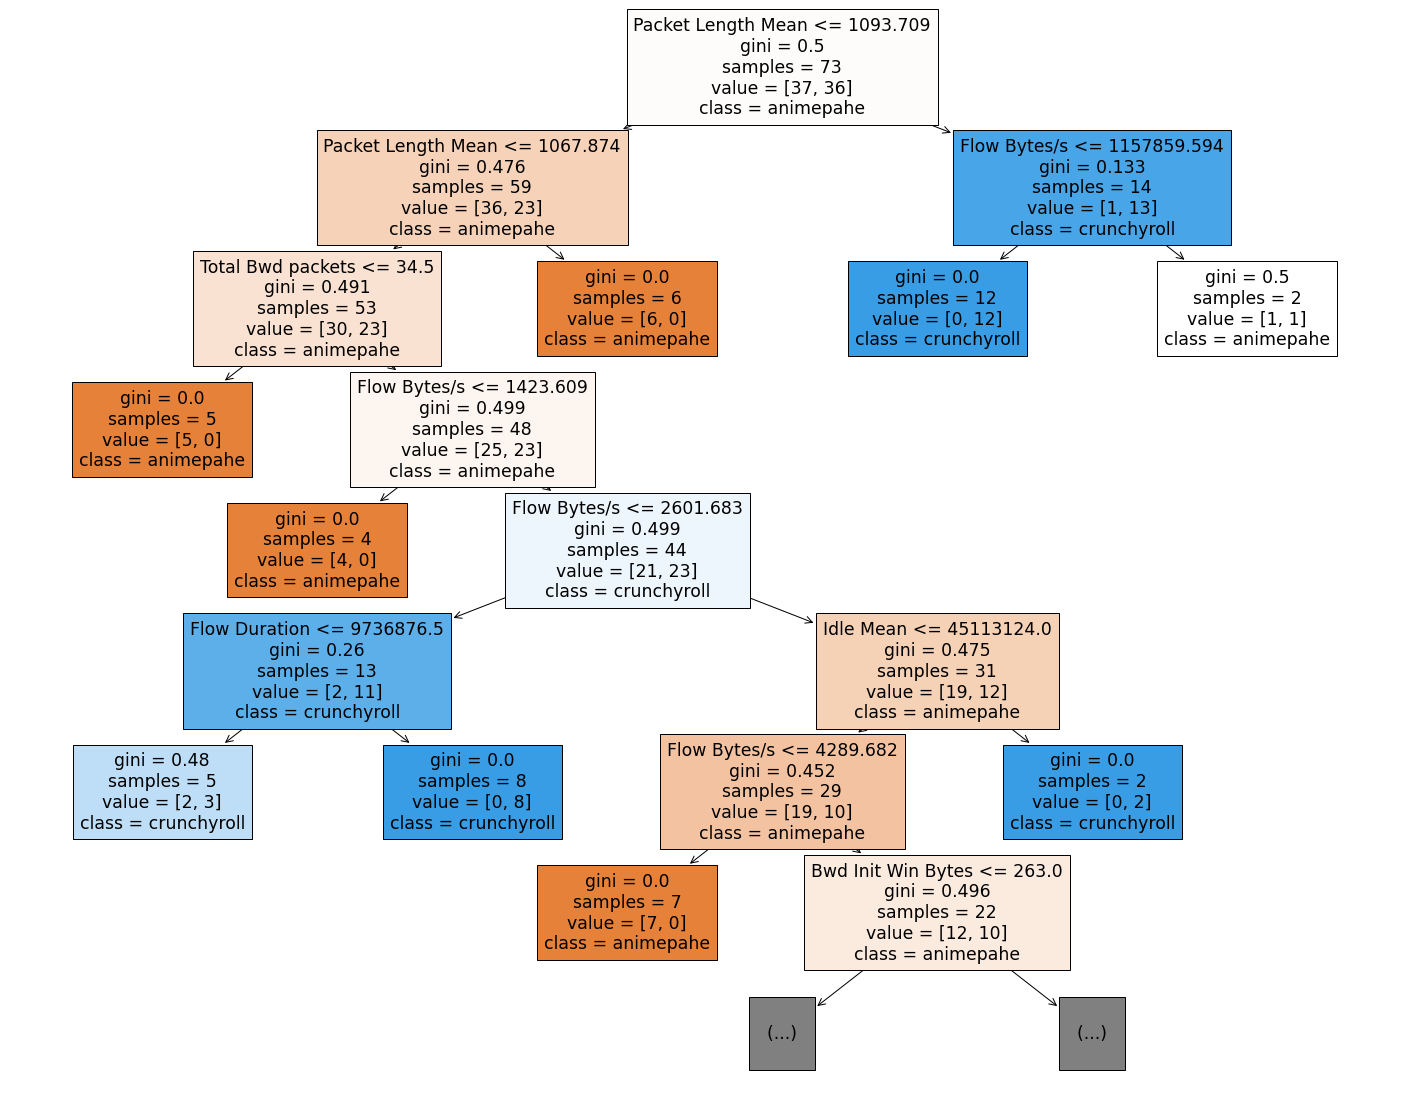

In [28]:
# Create and Train a Trustee Tree
trustee = ClassificationTrustee(expert=clf)
trustee.fit(x_train, y_train, num_samples=len(x_train) // 2, num_iter=20, train_size=0.99)

# Display Trustee Results
_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")
dt_y_pred = dt.predict(x_train)
print("Model explanation global fidelity report:")
print(metrics.classification_report(clf.predict(x_train), dt_y_pred))
print("Model explanation score report:")
print(metrics.classification_report(y_train, dt_y_pred))

# plot a tree
fig = plt.figure(figsize=(25,20))
plot_tree(dt, feature_names=x_train.columns, class_names=sorted(df_features['Label'].unique()), filled=True, max_depth=7)